In [356]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np
import pywt
from skimage.measure import block_reduce

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

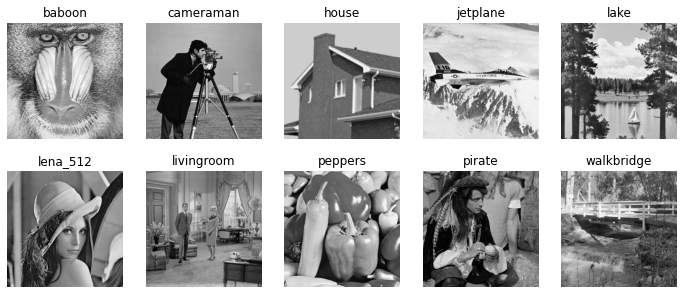

In [358]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [359]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])

In [360]:
dataset.shape

(10, 512, 512)

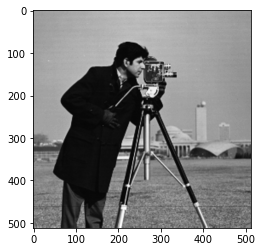

In [361]:
plt.imshow(dataset[1], cmap='gray')

Делаем downsampling во имя производительности.

In [362]:
downsampling_scale = 2
d = 9 - downsampling_scale
n = 2 ** d
block_size = (2 ** downsampling_scale, 2 ** downsampling_scale)

dataset_new = np.empty((10, n, n), dtype=dataset.dtype)
for i in range(10):
    dataset_new[i] = np.round(block_reduce(dataset[i], block_size, np.mean))

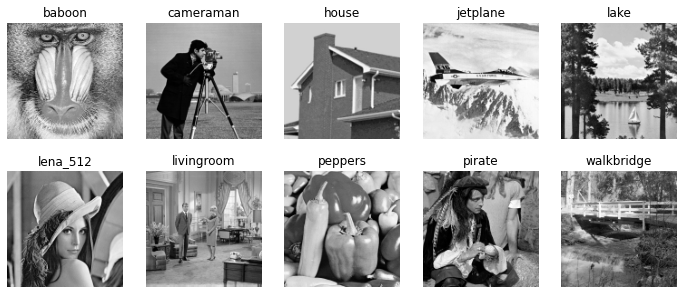

In [363]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(dataset_new[cnt], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

Чуть менее качественно, чем было изначально, но для массовых экспериментов скорость важнее.

In [364]:
matrix_modes = [2] * d
original = dataset_new[1]

vector, vector_modes = utils.matrix_to_vector(original, d, matrix_modes)

In [365]:
preproc = wrappers.RPCA_preprocessing_wrapper(2)

In [366]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=1,
    max_iter=150
)

In [367]:
ranks

[4, 16, 55, 40, 9, 3]

In [368]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

In [369]:
print(np.sum(np.isclose(original, low_rank_matrix)), original.size)
print(np.sum([s.data.size for s in sparse_parts]), original.size)

0 16384
62592 16384


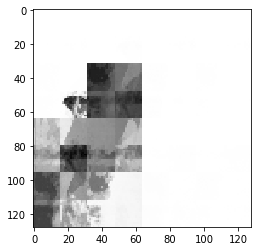

In [370]:
plt.imshow(low_rank_matrix, interpolation='nearest', cmap='gray')

Почти всё улетело в sparse-часть, так что лямбду надо повышать.

In [371]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=3,
    max_iter=150
)

print(ranks)
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
print(np.sum(np.isclose(original, low_rank_matrix)), original.size)
print(np.sum([s.data.size for s in sparse_parts]), original.size)

[4, 16, 64, 64, 16, 4]
14357 16384
1784 16384


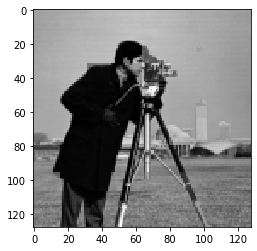

In [372]:
plt.imshow(low_rank_matrix, interpolation='nearest', cmap='gray')

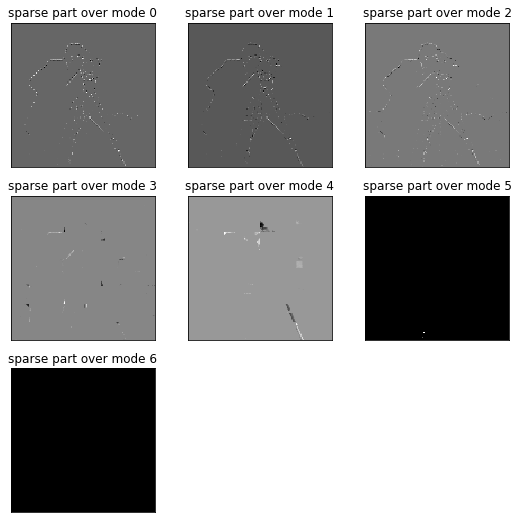

In [373]:
sparse_to_show = utils.restore_matrices(preproc.sparse_parts, d, vector_modes)

fig = plt.figure(figsize=(9, 9))
for i in range(d):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))

In [374]:
sum_sparse = np.sum(sparse_to_show, axis=0)
print(np.linalg.norm(original - sum_sparse - low_rank_matrix) / np.linalg.norm(original))
print(utils.psnr(original, sum_sparse + low_rank_matrix))
#для сравнения
print(utils.psnr(original, low_rank_matrix))

1.5567468429573068e-06
121.81514295061082
32.47181094034033


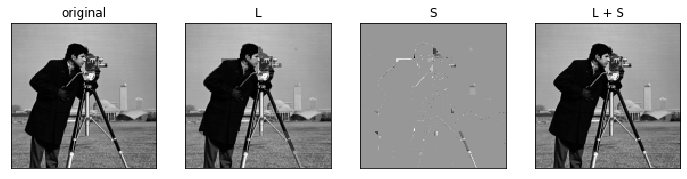

In [375]:
fig = plt.figure(figsize=(12, 3))
data_to_show = [original, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'L', 'S', 'L + S']
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Можно захотеть подобрать лямбду так, чтобы в S улетало всё же что-то значительное (но не всё)...

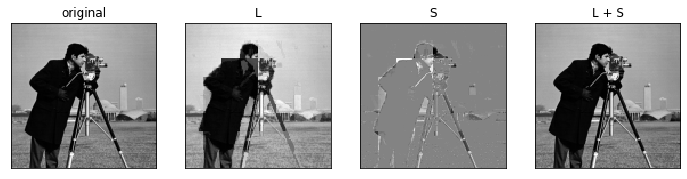

In [376]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=1.9,
    max_iter=250
)

low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
sum_sparse = np.sum(
    utils.restore_matrices(preproc.sparse_parts, d, vector_modes),
    axis=0
)

data_to_show = [original, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'L', 'S', 'L + S']
fig = plt.figure(figsize=(12, 3))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

In [377]:
ranks

[4, 16, 64, 64, 16, 4]

Можно получить не полные ранги, если брать совсем маленькую лямбду... Или ограничивать ранги сверху, вторая версия препроцессинга это умеет. Да и первую тоже можно обучить.

Попробуем потестировать на salt-and-pepper noise, что ли...

In [378]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
#вообще, наверное, есть более-менее строгое определение, но я его не нашёл

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

$$p \in [0,1/2] \Rightarrow \hat{A}_{ij} = \begin{cases}
0 &\text{с вероятностью $p$} \\
255 &\text{с вероятностью $p$} \\
A_{ij} &\text{с вероятностью $1 - 2p$} \\
\end{cases}$$
Броски независимые для разных $i,j$.

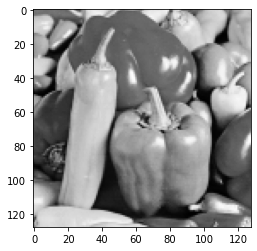

In [379]:
original = dataset_new[7]
plt.imshow(original, cmap='gray')

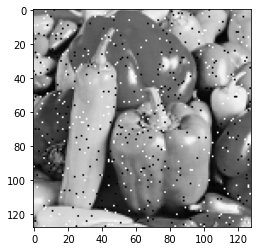

In [380]:
noisy = sp_noise(original, 0.02)
plt.imshow(noisy, cmap='gray')

Посмотрим, уберётся ли шум в малоранговой части нашего RPCA:

In [381]:
vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)

In [382]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=2.,
    max_iter=400
)

In [383]:
ranks

[4, 16, 64, 64, 16, 4]

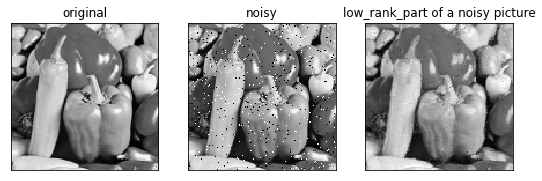

In [384]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

fig = plt.figure(figsize=(9, 3))
data_to_show = [original, noisy, low_rank_matrix]
data_labels = ['original', 'noisy', 'low_rank_part of a noisy picture']
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Сложим разреженные части:

In [385]:
sparse_to_show = utils.restore_matrices(preproc.sparse_parts, d, vector_modes)
sum_sparse = np.sum(sparse_to_show, axis=0)

Нарисуем разреженные части теперь:

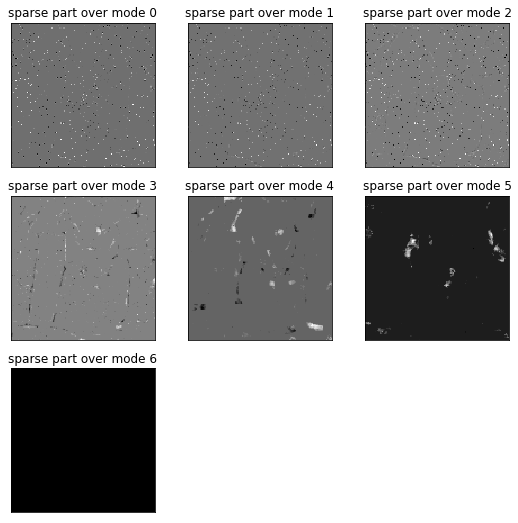

In [386]:
fig = plt.figure(figsize=(9, 9))
for i in range(d):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Правда ли, что low_rank_part ближе к оригинальному изображению, нежели к шуму? 

In [387]:
print(np.linalg.norm(low_rank_matrix - noisy) / np.linalg.norm(original))
print(np.linalg.norm(low_rank_matrix - original) / np.linalg.norm(original))
print()
print(utils.psnr(low_rank_matrix, noisy))
print(utils.psnr(low_rank_matrix, original))

0.16847714102003106
0.08583748921698285

20.308059910395976
26.16533947599075


Ненамного, но да, ближе.

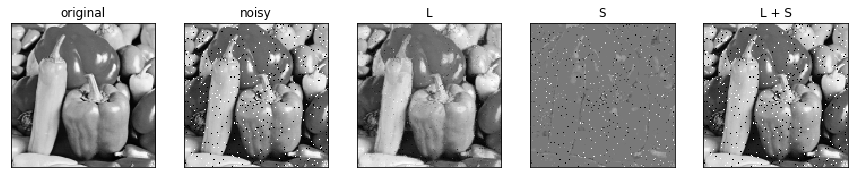

In [388]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Протестируем верхнее жёсткое ограничение на ранг:

In [389]:
low_rank_part, sparse_parts, ranks = preproc.adjust(
    vector,
    d,
    vector_modes,
    upper_ranks=[4,12,48,48,12,4],
    lambda_scale=2.,
    max_iter=400
)

In [390]:
ranks

[4, 12, 48, 48, 12, 4]

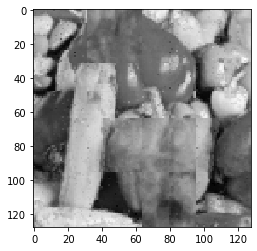

In [391]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)
plt.imshow(low_rank_matrix, interpolation="nearest", cmap='gray')

Как будто покорёжено, но шума с виду меньше.

In [392]:
sparse_to_show = utils.restore_matrices(preproc.sparse_parts, d, vector_modes)
sum_sparse = np.sum(sparse_to_show, axis=0)

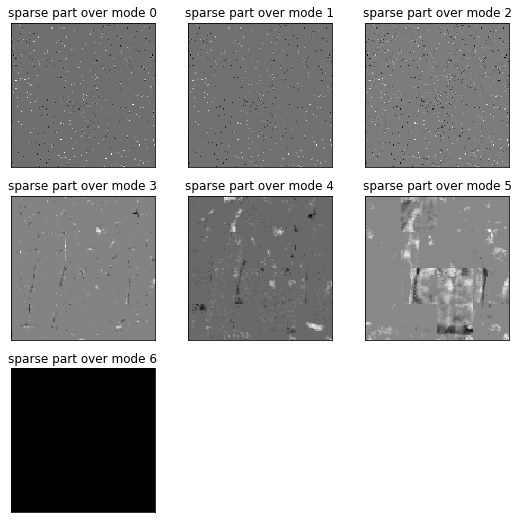

In [393]:
fig = plt.figure(figsize=(9, 9))
for i in range(d):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Всё же деталей в sparse-части теперь много уходит...

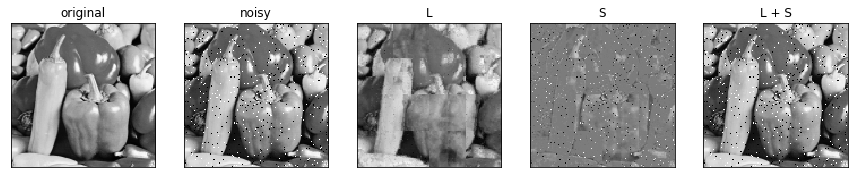

In [394]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, low_rank_matrix, sum_sparse, sum_sparse + low_rank_matrix]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Обычный RPCA (просто к матрице применённый):

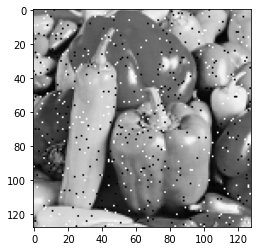

In [395]:
plt.imshow(noisy, cmap='gray')

In [396]:
r_pca_usual = r_pca.R_pca(noisy)
l, s = r_pca_usual.fit(max_iter=600, iter_print=40)

iteration: 1, error: 38.82274504910379
iteration: 40, error: 1.4850898309293445
iteration: 80, error: 1.0192146467606613
iteration: 120, error: 0.887168320567354
iteration: 160, error: 0.6489217518191026
iteration: 200, error: 0.4628290579094391
iteration: 240, error: 0.26461939516516103
iteration: 280, error: 0.15341789735437508
iteration: 320, error: 0.09951153183035764
iteration: 360, error: 0.07231117695196297
iteration: 400, error: 0.05723725927961028
iteration: 440, error: 0.039172551573708615
iteration: 480, error: 0.027066335413455024
iteration: 520, error: 0.02116234003706022
iteration: 560, error: 0.01597713186014596
iteration: 600, error: 0.012464742495882966


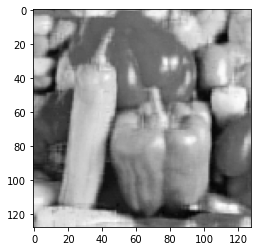

In [397]:
plt.imshow(l, cmap='gray')

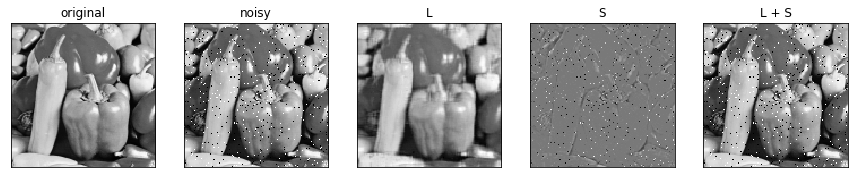

In [398]:
fig = plt.figure(figsize=(15, 3))
data_to_show = [original, noisy, l, s, l + s]
data_labels = ['original', 'noisy', 'L', 'S', 'L + S']
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Есть идея для эксперимента: перебирать параметр шума, сравнить обычный RPCA (применяемый к матрице напрямую) и наш тензоризованный. График: PSNR от значения параметра (оба будут убывать, что логично, но хотелось бы, чтобы для нашего тензоризованного RPCA график шёл выше).

In [399]:
original = dataset_new[7]
p_values = np.linspace(0.002, 0.2, 50)

tt_rpca_1 = wrappers.RPCA_preprocessing_wrapper(1)
tt_rpca_2 = wrappers.RPCA_preprocessing_wrapper(2)

results = [[] for _ in range(6)]

lrp = [[] for _ in range(5)]

for p in p_values:
    noisy = sp_noise(original, p)
    vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)
    
    for i in range(5):
        if i == 0 or i == 2:
            l, s, r = tt_rpca_1.adjust(
                vector, d, vector_modes,
                upper_ranks=None if i == 0 else [4, 15, 60, 60, 15, 4],
                lambda_scale=1.6, max_iter=200
            )
        elif i == 1 or i == 3:
            l, s, r = tt_rpca_2.adjust(
                vector, d, vector_modes,
                upper_ranks=None if i == 1 else [4, 15, 60, 60, 15, 4],
                lambda_scale=2, max_iter=200
            )
        elif i == 4:
            rpca = r_pca.R_pca(noisy)
            l, s = rpca.fit(max_iter=200, verbose=False)

        if i == 4:
            l_matrix = l
        else:
            l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]
            
        l_matrix = np.round(l_matrix)
        l_matrix[l_matrix < 0] = 0
        l_matrix[l_matrix > 255] = 255
        l_matrix = l_matrix.astype(original.dtype)
    
        results[i].append(utils.psnr(original, l_matrix))
        
        lrp[i].append(l_matrix)
        
    results[5].append(utils.psnr(original, noisy))

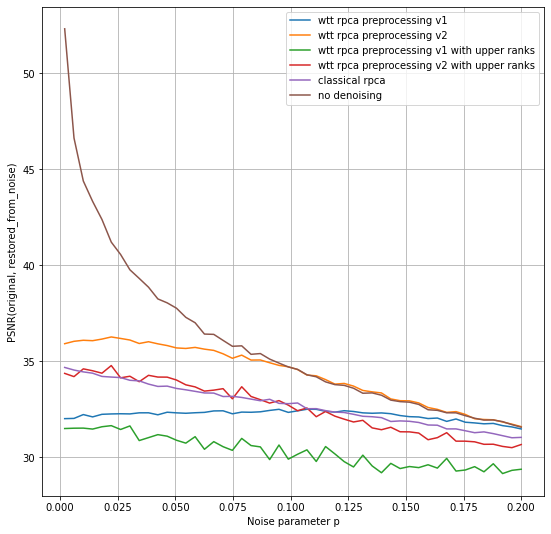

In [410]:
alg_names = [
    "wtt rpca preprocessing v1",
    "wtt rpca preprocessing v2",
    "wtt rpca preprocessing v1 with upper ranks",
    "wtt rpca preprocessing v2 with upper ranks",
    "classical rpca",
    "no denoising"
]

plt.figure(figsize=(9,9))
for i in range(6):
    plt.plot(p_values, results[i], label=alg_names[i])
plt.xlabel('Noise parameter p')
plt.ylabel('PSNR(original, restored_from_noise)')
plt.legend()
plt.grid()

plt.savefig('denoising_1.png')

In [411]:
noisy = sp_noise(original, 0.008)
vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)

restored = []
for i in range(5):
    if i == 0 or i == 2:
        l, s, r = tt_rpca_1.adjust(
            vector, d, vector_modes,
            upper_ranks=None if i == 0 else [4, 15, 60, 60, 15, 4],
            lambda_scale=1.6, max_iter=200
        )
    elif i == 1 or i == 3:
        l, s, r = tt_rpca_2.adjust(
            vector, d, vector_modes,
            upper_ranks=None if i == 1 else [4, 15, 60, 60, 15, 4],
            lambda_scale=2, max_iter=200
        )
    elif i == 4:
        rpca = r_pca.R_pca(noisy)
        l, s = rpca.fit(max_iter=200, verbose=False)

    if i == 4:
        l_matrix = l
    else:
        l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]

    l_matrix = np.round(l_matrix)
    l_matrix[l_matrix < 0] = 0
    l_matrix[l_matrix > 255] = 255
    l_matrix = l_matrix.astype(original.dtype)
    
    restored.append(l_matrix)

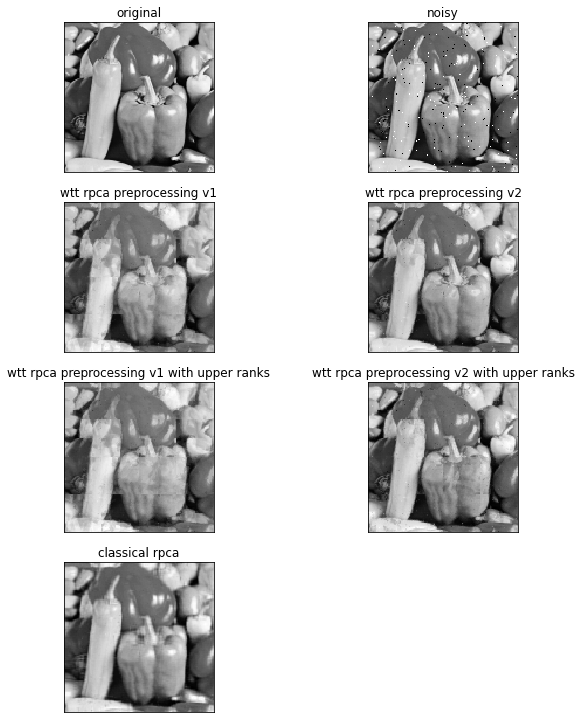

In [412]:
fig = plt.figure(figsize=(10, 16))
data_to_show = [original, noisy] + restored
data_labels = ['original', 'noisy'] + alg_names[:-1]
for i in range(len(data_to_show)):
    ax = fig.add_subplot(5, 2, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.savefig('denoising_2.png')

In [403]:
for i in range(1, len(data_to_show)):
    print("PSNR between original and", data_labels[i], "is", utils.psnr(data_to_show[0], data_to_show[i]))

PSNR between original and noisy is 45.70148354052953
PSNR between original and wtt rpca preprocessing v1 is 32.076215605390544
PSNR between original and wtt rpca preprocessing v2 is 35.991208792722716
PSNR between original and wtt rpca preprocessing v1 with upper ranks is 31.577031920239257
PSNR between original and wtt rpca preprocessing v2 with upper ranks is 34.32477209906309
PSNR between original and classical rpca is 34.41084046688766
